0.9584301138199486
186815068.4931509
[135.78767123]
180616.43835616432
    Area  PredictedPrices
0   1000     3.164041e+05
1   1500     3.842979e+05
2   2300     4.929281e+05
3   3540     6.613048e+05
4   4120     7.400616e+05
5   4560     7.998082e+05
6   5490     9.260908e+05
7   3460     6.504418e+05
8   4750     8.256079e+05
9   2300     4.929281e+05
10  9000     1.402705e+06
11  8600     1.348390e+06
12  7100     1.144709e+06
Predicted price for an area of 3000 is : [587979.45205479]


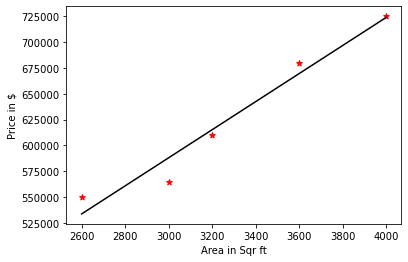

In [5]:
# This is a good example of how to use Linear Regression single variable with data in SQL Server tables
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc

# Step 1: get your data from SQL Server and assign it to a pandas variable
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
query_str = "SELECT * FROM [Tutorial].[dbo].[AreasActualPrice]"
df = pd.read_sql(sql=query_str, con=conn_str)

# Step 2: Let's do a quick scatter plot to get an idea of the shape of the data. You need to pass in (x,y) variable
plt.xlabel('Area in Sqr ft')
plt.ylabel('Price in $')
plt.scatter(df.Area,df.Price, color = 'red', marker= '*')

# Step 3: fit your model to use available datasets.
reg = linear_model.LinearRegression() # get linear regression object
reg.fit(df[['Area']],df.Price) # fit your linear regression model. Note that your independent first argument is a 2d array

# Step 4 : let's plot the predicted price. Pass in your x variable to a predict function to get y. Note that predict takes 2d array
plt.plot(df.Area,reg.predict(df[['Area']]),color = 'black') # pass in the list array of x into predict to get y
predicted_price = reg.predict(df[['Area']])
gradient = reg.coef_ # this gives you the gradient or slope
intercept = reg.intercept_ # this gives you the intercept on the y axix.

# It is important to know how the relationship between the values of the x-axis and the values of the y-axis is, if there are 
# no relationship the linear regression can not be used to predict anything. The r-squared value ranges from 0 to 1, where 0 means no relationship, 
# and 1 means 100% related.
r2 = r2_score(df.Price,predicted_price)
mse = mean_squared_error(df.Price,predicted_price)

print(r2)
print(mse)
print(gradient)
print(intercept)

# Step 5 : Now let's predict the price for any given area. 
# let's get the sql table containing only areas and predict price for each area.
# get your data and assign it to a pandas variable areasize

conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
myquery_str = "SELECT [Area] FROM [Tutorial].[dbo].[Areas]"
areasize = pd.read_sql(sql=myquery_str, con=conn_str)

# Now, let's get the predicted prices for any given areas.
# remember to go back to your fit model ie reg and pass in variable areasize ( this is your x axix) to your predict function

p = reg.predict(areasize) # this gives you predicted prices that are now assign to variable p.

# now, let assign p to a newly created column namely PredictedPrices. Note that areasize is actually your pandas variable. It act like a table. you are simply adding
# a newly created PredictedPrices column to Pandas variable table namely areasize.

areasize['PredictedPrices'] = p
print(areasize)

cursor = conn_str.cursor()
#cursor.execute("truncate table  [Tutorial].[dbo].[AreasPredicted]")
cursor.execute("EXEC ClearAreasPredicted") # Run SP to truncate table before insertion below.
for i, row in areasize.iterrows():
    cursor.execute("INSERT INTO [Tutorial].[dbo].[AreasPredicted]([Area],[Price]) values(?,?)", row['Area'], row['PredictedPrices'] ) 
cursor.execute("EXEC LoadAreaPrice") # Run SP to load final table. Add status column to differenciate between predicted prices and actual prices

conn_str.commit()
cursor.close()
conn_str.close()

# Step 6: Finally you can save your model (reg) to a file using pickle. You can now give this file to your work collegue to make prediction.
# save your model to a writable binary (wb) and call dump function to write it to the specified path
import pickle
with open('C:\Python\My Files\model_pickle','wb') as f:
    pickle.dump(reg,f)
# read binary (rb) file and call load function to read from the file
with open('C:\Python\My Files\model_pickle','rb') as f:
    mp = pickle.load(f)
# now, let's test our model to predict the price for an area of 3000
print("Predicted price for an area of 3000 is :",mp.predict([[3000]]))


In [6]:
# Step 7: You can now give model_pickle file to your colleque. He or she will save it to a drive and can then run it in say Jupyter Notebook to make prediction.
#Your colleque will simply have to call the load function to open the file given to them and save this into a variable as shown below.

import pickle

var = pickle.load(open('C:\Python\My Files\model_pickle','rb'))
print("Predicted value :",var.predict([[3000]]))
print("My gradient is :" ,var.intercept_)
print("My coefficient is :", var.coef_)

Predicted value : [587979.45205479]
My gradient is : 180616.43835616432
My coefficient is : [135.78767123]


0.9550196399325818
446305128.22449404
[  112.06244194 23388.88007794 -3231.71790863]
221323.00186540443


array([498408.25158031, 578876.03748933])

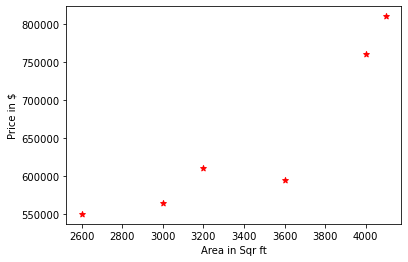

In [7]:
# This is a good example of how to use Linear Regression multiple variable (Multivariate) with data in excel
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc
import math

# Step 1: get your data from excel file and assign it to a pandas variable
df = pd.read_csv("C:\Python\My Files\homeprices_2.csv")
df

# let's do some data cleaning to replace the null value in bedrooms with the aveage bedroom size.
#let's get the average bedroom size
mean_bedrooms = df.bedrooms.mean()

#let's round this up to an interger
mean_bedrooms = math.floor(mean_bedrooms)

#let's fill in all the null values in bedrooms size with the aveage value above and assign the filled value back to our original bedroom
df.bedrooms = df.bedrooms.fillna(mean_bedrooms)
df.bedrooms


# Step 2: Let's do a quick scatter plot to get an idea of the shape of the data. Test individual independent variable one by one ie area as shown below.

#let's test the shape of the area
plt.xlabel('Area in Sqr ft')
plt.ylabel('Price in $')
plt.scatter(df.area,df.price, color = 'red', marker= '*')

# Step 3: fit your model to use available datasets.
reg = linear_model.LinearRegression() # get linear regression object
reg.fit(df[['area','bedrooms','age']],df.price) # fit your linear regression model. Note that your independent first argument is a 2d array

# Step 4 : let's get the predicted price. Pass in your x variable to a predict function to get y. Note that predict takes 2d array
predicted_price = reg.predict(df[['area','bedrooms','age']])
gradient = reg.coef_ # this gives you the gradient or slope
intercept = reg.intercept_ # this gives you the intercept on the y axix.

# It is important to know how the relationship between the values of the x-axis and the values of the y-axis is, if there are 
# no relationship the linear regression can not be used to predict anything. The r-squared value ranges from 0 to 1, where 0 means no relationship, 
# and 1 means 100% related.
r2 = r2_score(df.price,predicted_price)
mse = mean_squared_error(df.price,predicted_price)

print(r2)
print(mse)
print(gradient)
print(intercept)

# Step 5: Now let's get the price prediction for 
# 3000sq feet area, 3 bedrooms and 40 years old house and 
# 2500sq feet area, 4 bedrooms and 5 years old house

priceprediction = reg.predict([[3000,3,40],[2500,4,5]])
priceprediction


r2_score is : 0.977013901427314
mean_squared_error is : 2660640.909788399
gradients are : [2922.26901502 2221.30909959 2147.48256637]
intercept is : 14992.651446693148
Predicted salaries are : [53713.86677124 93747.79628651 52894.47750251 62333.02074986
 50296.73833353 80612.19757549 58680.56810626]
  experience  test_score_out_of_10  interview_score_out_of_10  \
0          2                     9                          6   
1         12                    10                         10   
2          4                     6                          6   
3          5                     7                          8   
4          6                     8                          0   
5          9                     9                          9   
6          0                    10                         10   

   PredictedSalaries  
0       53713.866771  
1       93747.796287  
2       52894.477503  
3       62333.020750  
4       50296.738334  
5       80612.197575  
6       58680.568

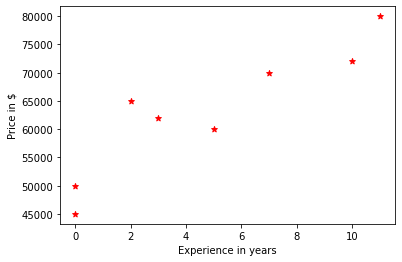

In [8]:
# This is a good example of how to use Linear Regression multiple variable (Multivariate)  with data in SQL Server tables
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pyodbc
from word2number import w2n
import math

# Step 1: get your data from SQL Server and assign it to a pandas variable
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
query_str = "SELECT * FROM [Tutorial].[dbo].[ActualHiring]"
df = pd.read_sql(sql=query_str, con=conn_str)
df
# Now, let's sort out the data quality issues by filling null with zero
df.experience = df.experience.fillna("Zero")

# Now, let's convert word numbers to numerical numbers for experience column
df.experience = df.experience.apply(w2n.word_to_num)


# let's sort out null value in test_score_out_of_10 column
# get the average value for test_score_out_of_10
test_score_updated = df.test_score_out_of_10.mean()
# convert the average value to integer
test_score_updated = math.floor(test_score_updated)
# fill the null value in the column with the new average value
df.test_score_out_of_10 = df.test_score_out_of_10.fillna(test_score_updated)
df

# Step 2: Let's do a quick scatter plot to get an idea of the shape of the data. Test individual independent variable one by one ie area as shown below.
plt.xlabel('Experience in years')
plt.ylabel('Price in $')
plt.scatter(df[['experience']],df.salary, color = 'red', marker= '*')

# Step 3: fit your model to use available datasets.
reg = linear_model.LinearRegression() # get linear regression object
reg.fit(df[['experience','test_score_out_of_10','interview_score_out_of_10']],df.salary) # fit your linear regression model. Note that your independent first argument is a 2d array

# Step 4 : let's get the predicted salary. Pass in your x variable to a predict function to get y. Note that predict takes 2d array
predicted_salary = reg.predict(df[['experience','test_score_out_of_10','interview_score_out_of_10']])
gradient = reg.coef_ # this gives you the gradient or slope
intercept = reg.intercept_ # this gives you the intercept on the y axix.

# It is important to know how the relationship between the values of the x-axis and the values of the y-axis is, if there are 
# no relationship the linear regression can not be used to predict anything. The r-squared value ranges from 0 to 1, where 0 means no relationship, 
# and 1 means 100% related.
r2 = r2_score(df.salary,predicted_salary)
mse = mean_squared_error(df.salary,predicted_salary)

print("r2_score is :",r2)
print("mean_squared_error is :",mse)
print("gradients are :" ,gradient)
print("intercept is :",intercept)

# Step 5 : Now let's predict the salary for any given experience,test_score_out_of_10 and interview_score_out_of_10. 
# let's get the sql table  and predict salary for the independent variables
# get your data and assign it to a pandas variable myvars

conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LAPTOP-CHKIB79A;''Database=Tutorial;''Trusted_Connection=yes;')
myquery_str = "SELECT  [experience] ,[test_score_out_of_10],[interview_score_out_of_10] FROM [Tutorial].[dbo].[PredictedHiring]"
myvars = pd.read_sql(sql=myquery_str, con=conn_str)

# Now, let's get the predicted salaries for all independent variables stored in myvars.
# remember to go back to your fit model ie reg and pass in variable myvars ( this is your x axix) to your predict function

p = reg.predict(myvars) # this gives you predicted prices that are now assign to variable p.

print("Predicted salaries are :", p)

# now, let assign p to a newly created column namely PredictedSalaries. Note that myvars is actually your pandas variable. It act like a table. You are simply adding
# a newly created PredictedSalaries column to Pandas variable table namely myvars.


myvars['PredictedSalaries'] = p
print(myvars)

# The next step is to map your pandas columns to the columns in your sql table namely PredictedHiring
# use the connection string to call cursor() function
cursor = conn_str.cursor()
cursor.execute("truncate table  [Tutorial].[dbo].[ActualPredictedHiring]")  #truncate table before insertion
for i, row in myvars.iterrows():
    cursor.execute("INSERT INTO [Tutorial].[dbo].[ActualPredictedHiring]([experience],[test_score_out_of_10],[interview_score_out_of_10],[salary] ) \
    values(?,?,?,?)", row['experience'], row['test_score_out_of_10'],row['interview_score_out_of_10'],row['PredictedSalaries'] ) 


conn_str.commit()
cursor.close()
conn_str.close()
